In [1]:
import pickle
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline


from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text



from sklearn.metrics import plot_roc_curve, roc_auc_score
from sklearn import metrics

In [2]:
with open('corpus.pkl','rb') as clean_pickle:
    corpus = pickle.load(clean_pickle)

In [3]:
corpus.rename(columns={"subreddit":"fact"}, inplace = True)
corpus.fact = np.where(corpus.fact == 'facts', 1,0)

# Functions

___

In [4]:
from myfunct import *

# Train/Test

In [5]:
X = corpus['selftext']
y = corpus['fact']

In [6]:
X_train,X_test,y_train,y_test = train_test_split(X,y, 
                                                stratify = y,
                                                random_state = 42)

# Create Pipelines

___

We will begin by fitting our Lemmitized text through a large number of applicable models in search of two models to explore further. We are looking for the model with the highest scores regardless of their train/test gap, and for the model with the tightest train/test gap regardless of scores. We will then tune each of those two for ideal paramters and compare the results.

## Logistic Regression 

In [7]:

logreg_Ridge_1_cv= Pipeline([('cvec', CountVectorizer(stop_words = 'english')),
                  ('Log_reg',LogisticRegression(solver = 'liblinear'))])

logreg_Ridge_10_cv= Pipeline([('cvec', CountVectorizer(stop_words = 'english')),
                  ('Log_reg', LogisticRegression(C = 10.0 , solver = 'liblinear'))])

logreg_Lasso_1_cv = Pipeline([('cvec', CountVectorizer(stop_words = 'english')),
                  ('Log_reg',  LogisticRegression(penalty = 'l1',solver = 'liblinear'))])

logreg_Lasso_10_cv = Pipeline([('cvec', CountVectorizer(stop_words = 'english')),
                  ('Log_reg',  LogisticRegression(penalty = 'l1', C=10.0, solver = 'liblinear'))])


## Multinomial Naive Bayes

In [8]:

# multinomial 
mnb_cv = Pipeline([
        ('cvec', CountVectorizer(stop_words = 'english')),
        ('nb', MultinomialNB())]);

mnb_tf = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('nb', MultinomialNB())]);

## Naive Bayse

In [9]:
nb_cv = Pipeline([
        ('cvec', CountVectorizer(stop_words = 'english')),
        ('Nb',BernoulliNB())]);

nb_tf = Pipeline([
        ('tfidf',TfidfVectorizer()),
        ('Nb',BernoulliNB())]);


## Support Vectors

In [10]:
# we need to use this calibrator so that we can plot the svm model's ROC curve latter 
svm = LinearSVC()
svm = CalibratedClassifierCV(svm)

In [11]:
svm_cv = Pipeline([
    ('cvec', CountVectorizer()),
    ('scv',svm)
]);

svm_tf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('scv',svm)
]);



# Iterator

In [12]:
pipelines = [
    ("logreg_Lasso_1_cv", logreg_Lasso_1_cv),
    ("logreg_Lasso_10_cv", logreg_Lasso_10_cv),
    ("logreg_Ridge_1_cv", logreg_Ridge_1_cv),
    ("logreg_Ridge_10_cv", logreg_Ridge_10_cv),
    ("mnb_cv", mnb_cv),
    ("mnb_tf", mnb_tf),
    ("nb_cv", nb_cv), 
    ("nb_tf", nb_cv),
    ("svm_cv", svm_cv), 
    ("svm_tf", svm_tf)
]

## Fit

In [13]:
fit_pipes(pipelines,X_train,y_train)        

# Evaluate

In [14]:
# train_scores = score_pipes(pipelines,X_train,y_train)
# test_scores = score_pipes(pipelines,X_test,y_test)
results = make_results_df(pipelines,X_train,y_train,X_test,y_test)

logreg_Lasso_1_cv Accuracy: 0.8998310403089549 
logreg_Lasso_10_cv Accuracy: 0.99637943519189 
logreg_Ridge_1_cv Accuracy: 0.9775524981897176 
logreg_Ridge_10_cv Accuracy: 0.99637943519189 
mnb_cv Accuracy: 0.9087617668356264 
mnb_tf Accuracy: 0.9370021723388848 
nb_cv Accuracy: 0.9222785421192373 
nb_tf Accuracy: 0.9222785421192373 
svm_cv Accuracy: 0.9237267680424813 
svm_tf Accuracy: 0.9905865314989138 
logreg_Lasso_1_cv Accuracy: 0.7603186097031137 
logreg_Lasso_10_cv Accuracy: 0.7595944967414917 
logreg_Ridge_1_cv Accuracy: 0.7697320782041999 
logreg_Ridge_10_cv Accuracy: 0.7653874004344677 
mnb_cv Accuracy: 0.78059377262853 
mnb_tf Accuracy: 0.7566980448950036 
nb_cv Accuracy: 0.7878349022447502 
nb_tf Accuracy: 0.7878349022447502 
svm_cv Accuracy: 0.7646632874728457 
svm_tf Accuracy: 0.77697320782042 


In [15]:
results.set_index('Model')

,Scores_x,Scores_y,Gap
Model,,,
logreg_Lasso_1_cv,0.899831,0.760319,0.139512
logreg_Lasso_10_cv,0.996379,0.759594,0.236785
logreg_Ridge_1_cv,0.977552,0.769732,0.207820
logreg_Ridge_10_cv,0.996379,0.765387,0.230992
mnb_cv,0.908762,0.780594,0.128168
mnb_tf,0.937002,0.756698,0.180304
nb_cv,0.922279,0.787835,0.134444
nb_tf,0.922279,0.787835,0.134444
svm_cv,0.923727,0.764663,0.159063


In [16]:
# import dataframe_image as dfi
# results.dfi.export('./TrainTest.png')

In [17]:
best_score(pipelines,X_test,y_test)

 Best Accuracy: 0.7878349022447502
Model: nb_cv


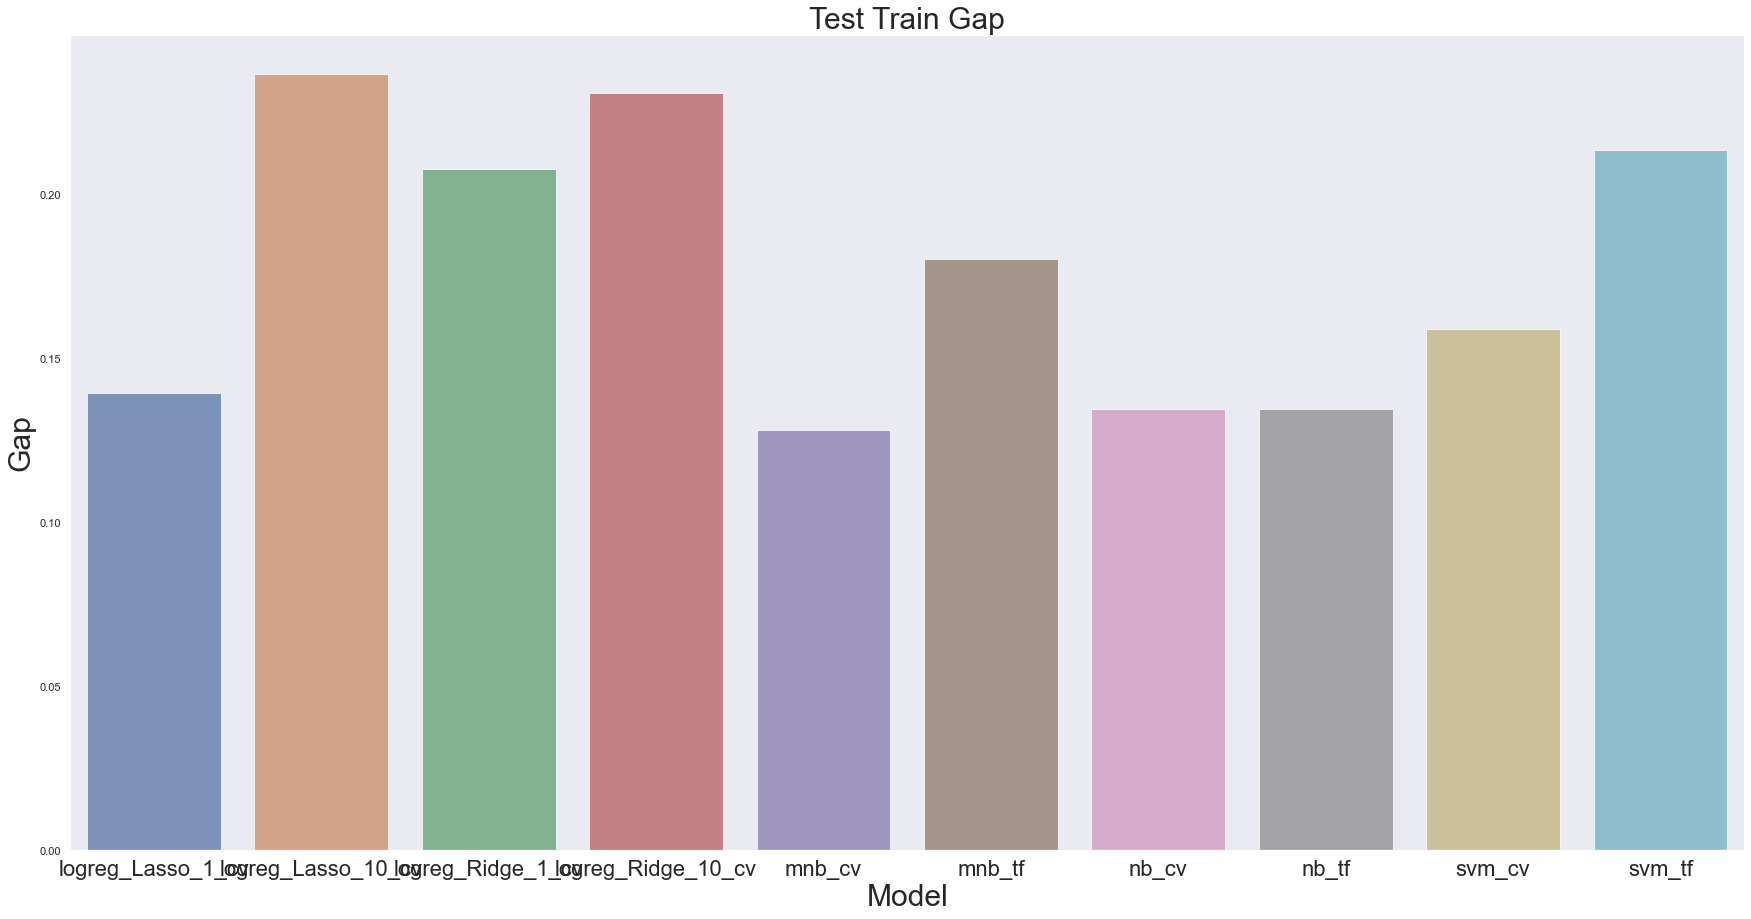

In [18]:
sns.set_theme(style = 'dark')
plt.figure(figsize=(30,15 ))
sns.barplot(x=[name for name, _ in pipelines], y=[gap for gap in results.Gap], alpha = .75);
plt.title('Test Train Gap', fontsize = 30)
plt.xlabel('Model', fontsize = 30)
plt.ylabel('Gap', fontsize = 30)
plt.xticks(fontsize = 22);
plt.savefig('test_train_gap.png')

Taking a look at our train/test scores and the Gap between them for each model we have decided to iteratively tune for a Logistic Regression, Mulinomial Naive Bayes, and Support Vector Machines models.

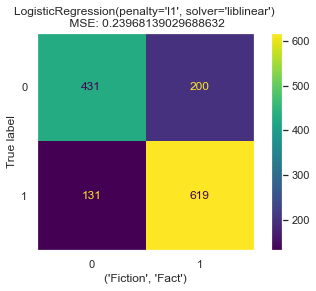

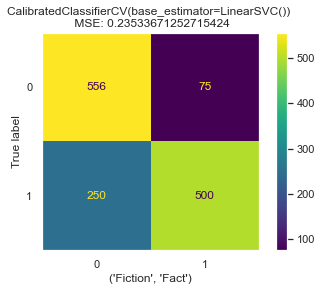

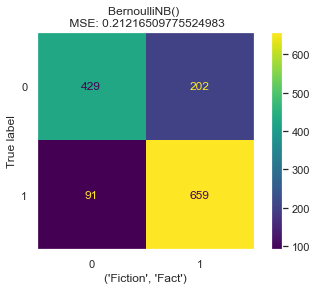

In [19]:

#     return fig
fig = disp_cm(logreg_Lasso_1_cv, X_test,y_test);
# plt.savefig('logreg_cm.png')

svm_display = disp_cm(svm_cv,X_test,y_test); 
# plt.savefig('svm_cm.png')

nb_display = disp_cm(nb_cv,X_test,y_test);
# plt.savefig('nb_cm.png')


# Selection 

Seing as our model is meant to create a feature in a social media filter, we actually want a little tiny bit of confusion in our final model. All three of these models are doing well. Now we will itteratively tune them.

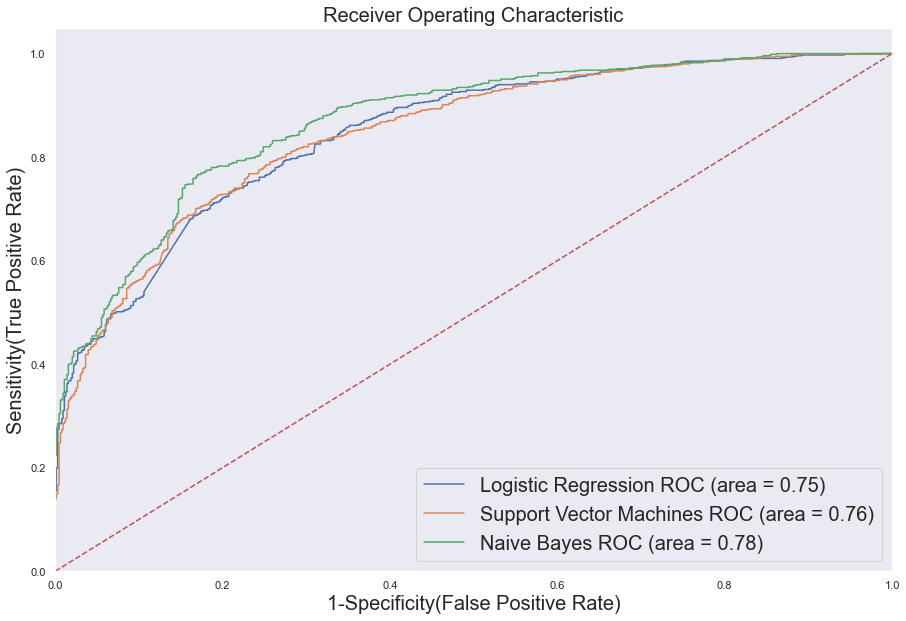

In [20]:
plt.figure(figsize = (15,10))
plt.savefig('ROC_plot.png')
# Add the models to the list that you want to view on the ROC plot
models = [
    {
        'label': 'Logistic Regression',
        'model': logreg_Lasso_1_cv,
    },
    {
        'label': 'Support Vector Machines',
        'model': svm_cv,
    },
    {
        'label': 'Naive Bayes',
        'model': nb_cv,
    }    

    ]

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    model.fit(X_train, y_train) # train the model
    y_pred=model.predict(X_test) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = metrics.roc_auc_score(y_test,model.predict(X_test))
    
    
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)',fontsize = 20)
plt.ylabel('Sensitivity(True Positive Rate)',fontsize = 20)
plt.title('Receiver Operating Characteristic', fontsize = 20)
plt.legend(loc="lower right",fontsize = 20)

plt.show()   # Display

